In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

import pandas as pd

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from R32_bmimBF4_PR import configuration
data = pd.read_csv('R32_bmimBF4.csv')

solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [3]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)

m.fs.properties.PR_kappa_A['bmimBF4', 'R32'].fix(-0.075332)
m.fs.properties.PR_kappa_A['R32', 'bmimBF4'].fix(-0.03569)
# m.fs.properties.PR_kappa_B['bmimBF4', 'R32'].fix(-0.69149)
# m.fs.properties.PR_kappa_B['R32', 'bmimBF4'].fix(-0.10862)



# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'bmimBF4'].unfix()

R32_x = np.zeros((len(data)))
P = np.zeros((len(data)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimBF4"] == m.fs.liq)

for i in range(len(data)):
    m.fs.liq = data["x_bmimBF4"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data["x_R32"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'bmimBF4'].fix(float(1-(data["x_R32"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data["temperature"].iloc[i]))
    
    print("x =", data["x_bmimBF4"].iloc[i])

    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

    #     m.fs.F101.report()
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R32_x[i] = "NaN"
            P[i] = "NaN"

x = 0.991
x = 0.901
x = 0.759
x = 0.626
x = 0.499
x = 0.373
x = 0.241
x = 0.993
x = 0.929
x = 0.825
x = 0.728
x = 0.641
x = 0.562
x = 0.485
x = 0.412
x = 0.996
x = 0.96
x = 0.901
x = 0.846
x = 0.794
x = 0.745
x = 0.699
x = 0.655
x = 0.998
x = 0.976
x = 0.942
x = 0.908
x = 0.875
x = 0.844
x = 0.814
x = 0.786


In [4]:
# print(P)
# print(data["pressure"])
# print(R125_x)
# print(data["x_R125"])

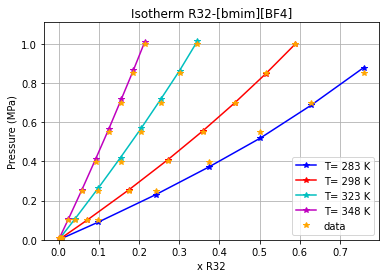

In [5]:
# for i in range(len(P)):
#     P[i] = P[i]*1e6
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

    
plt.plot(R32_x[0:7],P1[0:7],"b*-",label="T= 283 K")  
plt.plot(R32_x[7:15],P1[7:15],"r*-",label="T= 298 K") 
plt.plot(R32_x[15:23],P1[15:23],"c*-",label="T= 323 K") 
plt.plot(R32_x[23:],P1[23:],"m*-",label="T= 348 K")
plt.plot(data["x_R32"],data["pressure"]/1e6,"*",color='orange',label="data")  
plt.title('Isotherm R32-[bmim][BF4]')
plt.ylabel('Pressure (MPa)')
plt.xlabel('x R32')
plt.grid(True)
plt.ylim(0,1.110000)
plt.legend()
plt.show()

In [6]:
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value   : Fixed : Bounds
          Heat Duty : -36.230 : False : (None, None)
    Pressure Change :  9380.2 : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                              Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                   1.0000      0.12723       0.87277  
    mole_frac_comp bmimBF4    0.68600   1.0000e-08       0.78600  
    mole_frac_comp R32        0.31400       1.0000       0.21400  
    temperature                348.10       348.10        348.10  
    pressure               9.9990e+05   1.0093e+06    1.0093e+06  


In [7]:
# print(P1)

In [8]:
df = pd.DataFrame(P)
# df.to_csv('P_cons_32.csv')
# df.to_csv('P_lin_32_BF4.csv')
# df.to_csv('P_ter_32.csv')
# df.to_csv('P_x_32.csv')